# Linear logistic regression with HMC

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import time

from hamiltonian_mc import HamiltonianMonteCarlo, GPGradientHMC

# turn off numpy multithreading
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import sys

sys.path.append('../../src')
from inference import DerivativeGaussianProcess
from kernels import RBF, ExponentialKernel, LinearKernel

In [4]:
class Logistic:
    """
    Logistic regression model
    """

    def __init__(self, data_X, data_y, alpha):
        """
        data_X: (N, D); data_y: (N, 1), alpha: float
        """
        self.X = data_X
        self.y = data_y
        self.alpha = alpha

    def _loglikelihood(self, beta):
        """
        Log logistic regression likelihood of beta.
        beta: (D, M)
        """
        return(- (np.log(np.exp(self.X @ beta) + 1.0)).sum(axis=0) \
            + np.dot(np.transpose(self.y), np.dot(self.X, beta)))
    
    def _grad_loglikelihood(self, beta):
        """
        Gradient of Log logistic regression likelihood wrt beta.
        beta: (D, M)
        """
        return self.X.T @ (self.y - 1./(1. + np.exp(-self.X @ beta)))

    def _logprior(self, beta):
        """
        Log independent Gaussian prior density of beta.
        """
        return -0.5/self.alpha * (beta**2).sum(axis=0)
    
    def _grad_logprior(self, beta):
        """
        Gradient of Log independent Gaussian prior density wrt beta.
        """
        return - beta / self.alpha

    def get_dim(self):
        return(self.X.shape[1])

    def energy(self, beta):
        return -(self._loglikelihood(beta) + self._logprior(beta))

    def gradient(self, beta):
        return - (self._grad_loglikelihood(beta) + self._grad_logprior(beta))
    
    def scale(self):
        """
        Typical scale of the energy is N / D (causing it to get really large with increasing N)
        """
        return self.X.shape[1] / self.X.shape[0]

In [5]:
def generate_logreg_data(n, beta, prior, sigma=2.):
    """Generate logistic regression data.
    
    # Arguments
        n: number of observations
        beta: regression coefficient vector
        prior: Uniform or Gaussian
        sigma: parameter of prior (width of hypercube or Gaussian std. dev.)
        
    # Returns
        A list of design matrix and response vector
    """
    d = beta.shape[0]
    if prior == 'Uniform':
        X = np.random.rand(n, d)*sigma - 1./sigma
    elif prior == 'Gaussian':
        X = np.sqrt(sigma) * np.random.randn(n, d)
        
    mu = 1.0 / (1.0 + np.exp(-np.dot(X, beta)))
    Y = np.random.binomial(1, mu) * 1.0
    return(X, Y)

## Generate synthetic data

In [26]:
dim = 20
nx = 1000

np.random.seed(0)

theta = 2.*np.random.rand(dim, 1) -1.   # True theta is in [-1,1]
X, Y = generate_logreg_data(nx, theta, 'Uniform', 2.)   # X data is in [-1, 1]

prior_var = 4.
logreg = Logistic(X, Y, prior_var)

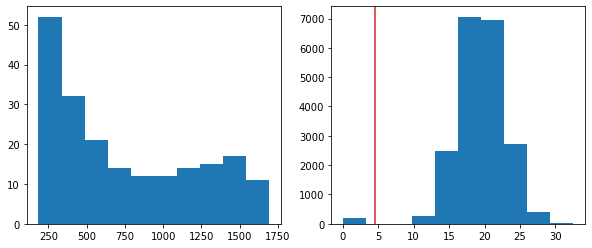

In [27]:
# Plot typical gradients and distances from prior samples
tsamples = (np.random.randn(dim, 200)*np.sqrt(10)).T  # prior samples of theta
prior_dists = np.triu(np.sqrt(((tsamples[:, None, :] - tsamples[None, ...])**2).sum(axis=-1)))[np.triu_indices(200)]

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(np.linalg.norm(logreg.gradient(tsamples.T), axis=0), label='gradients')

ax[1].hist(prior_dists, label='distances')
ax[1].axvline(np.sqrt(dim), c='C3')


# np.linalg.norm(logreg.gradient(theta + 1.e0 * np.random.normal(theta.shape)))

## Hamiltonian Monte Carlo

Dealing with a scaled Hamiltonian:   
HMC relies on a good balance between potential and kinetic energy. In the particular case of logistic regression, the potential energy scales roughly with $\alpha = N/D$ as compared to the kinetic energy (which grows linearly in $D$, thus the factor of $1/D$ in $\alpha$).
The most straightforward way is to _choose_ the momentum such that the kinetic energy $K$ is of the same scale as the potential energy. This can be achieved by modifying the mass of the particle: A larger mass will entail a larger kinetic energy.
Let
$$H(q, p) = E(q) + K(p)$$
where $K(p) = \frac{p^T p}{2m}$. Define $K_0 (p)$ as the kinetic energy for $m=1$, such that $K(p) = \frac{K_0(p)}{m}$. Then $p \sim \mathcal{N} (0, m)$. We can rewrite the Hamiltonian as
\begin{align}
H(q, p) &= E(q) + \frac{K_0(p)}{m}\\
\tilde{H} (q, p) & \equiv m H(q, p) = m E(q) + K_0(p),
\end{align}
note that $p$ still implicitly contains the mass!

The Hamiltonian EOM are

$$\frac{dq}{dt}  = \nabla_p H = \frac{p}{m} \qquad \frac{dp}{dt}  = -\nabla_q H = -\nabla_q E$$

leading to updates
```python
p = p - h / 2 * g
x = x + h * p / m
g = gradE(x)
p = p - h / 2 * g
```
so this doesn't entirely alleviate the issue that the magnitude of the gradient is a lot larger than the momentum.
On the other hand, this is an effect of the geometry of the problem in which the gradient is huge, so over small changes of the location the momentum changes by a lot (concentrated posterior).

<!-- Considering the modified Hamiltonian $\tilde{H} (q, p)$ these EOM become -->



In [47]:
seeds = np.arange(10) + 42

sqrt4_d = int(np.ceil(dim**0.25))
print(sqrt4_d)

T = 50 * sqrt4_d
# h = 3.e-1 / (sqrt4_d) # * logreg.scale()) TODO: Think about scaling the potential energy later.
h = 5.e-2 / (sqrt4_d) # * logreg.scale()) TODO: Think about scaling the potential energy later.


N_burn = dim
N_sample = 2000

mass=1./logreg.scale()

3


In [48]:
np.random.seed(seeds[0])
x0 = np.sqrt(prior_var)*np.random.randn(dim, 1)

hmc = HamiltonianMonteCarlo(logreg.energy, logreg.gradient, T, h, mass=1., N_burn=N_burn)

t_hmc = time.process_time()
X_hmc = hmc.sample(N_sample, x0)
t_hmc = time.process_time() - t_hmc

In [10]:
X_hmc.shape

(200, 100)

In [57]:
np.random.seed(seeds[0])
x0 = np.sqrt(prior_var)*np.random.randn(dim, 1)

# kern = RBF(dim, 1.5) #2./dim)
kern = RBF(dim, 10./dim) #2./dim)
gp = DerivativeGaussianProcess(kern)

tsam = (np.random.randn(dim, 25))
gp.condition(tsam, logreg.gradient(tsam))

gpg_hmc = GPGradientHMC(logreg.energy, logreg.gradient, gp_model=gp, T=T, h=h, mass=1./logreg.scale(), N_train=int(np.sqrt(dim)), N_burn=N_burn)
# gpg_hmc = GPGradientHMC(logreg.energy, logreg.gradient, gp, T, h, N_train=20, N_burn=N_burn)


t_gph = time.process_time()
X_gph = gpg_hmc.sample(N_sample, x0)
t_gph = time.process_time() - t_gph

In [58]:
gpg_hmc.gp_trainer.N_dat

25

In [30]:
gpg_hmc.diagnostics.info['N_hmc']

KeyError: 'N_hmc'

In [12]:
# gpg_hmc.diagnostics.info['dists']

In [13]:
X_gph.shape, gp.data.

SyntaxError: invalid syntax (<ipython-input-13-ec7d01d1c72c>, line 1)

In [11]:
print(t_hmc, t_gph)

22.153295256 25.244779257999998


In [59]:
hmc.diagnostics.acceptance_rate , gpg_hmc.diagnostics.acceptance_rate, gpg_hmc.gp_trainer.diagnostics.acceptance_rate

(0.9865000000000004, 1.0, 0.0)

In [13]:
gpg_hmc.gp_trainer.mode_gp

True

(19900,)

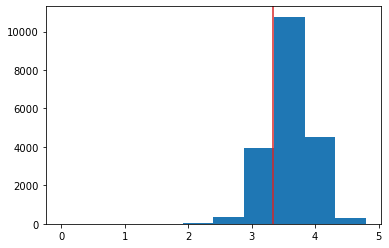

In [29]:
dists = np.triu(np.sqrt(((X_hmc[:, None, :] - X_hmc[None, :, :])**2).sum(axis=-1)))[np.triu_indices(N_sample, k=1)]
# dists = np.triu(np.sqrt((((gp.data['dX'].T)[None, :, :] - (gp.data['dX'].T)[:, None, :])**2).sum(axis=-1)))[np.triu_indices(5, k=1)]
plt.hist(dists)
plt.axvline(np.sqrt(dim)/np.log10(nx), c='C3')
dists.shape

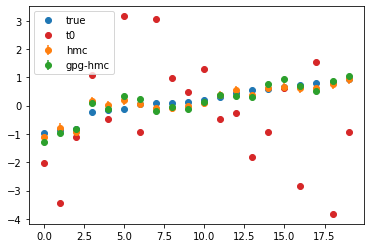

In [56]:
idx = np.argsort(theta[:,0])
plt.plot(theta[idx], 'o' , label='true')
# plt.plot(X_hmc.mean(axis=0)[idx], 'o', label='hmc')
plt.errorbar(np.arange(0, max(idx)+1), X_hmc.mean(axis=0)[idx], X_hmc.std(axis=0)[idx], marker='o', ls='', label='hmc')
# plt.plot(X_gph.mean(axis=0)[idx], 'o', label='gpg-hmc')
plt.errorbar(np.arange(0, max(idx)+1), X_gph.mean(axis=0)[idx], X_gph.std(axis=0)[idx], marker='o', ls='', label='gpg-hmc')
plt.plot(x0[idx], 'o', label='t0')
# plt.xlim(40,70)
# plt.ylim(-.1,.1)
plt.legend()

In [15]:
X_hmc.shape

(200, 100)

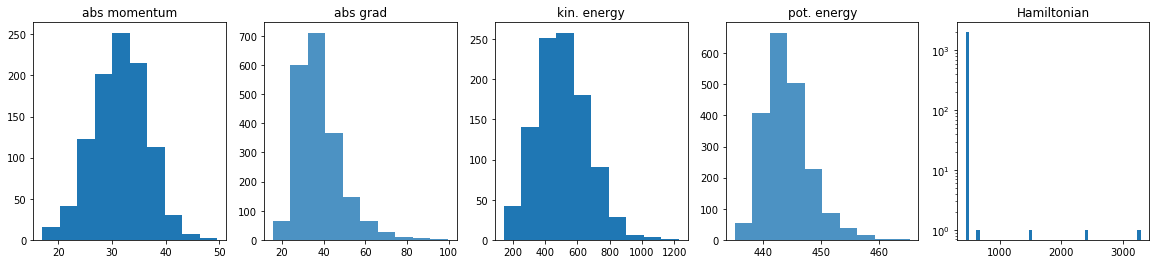

In [51]:
# understand momentum sampled -- typical norm is ~sqrt(D)
P = np.random.randn(dim, nx) * 1./np.sqrt(logreg.scale())
P_abs = np.linalg.norm(P, axis=0)

fig, ax = plt.subplots(1, 5, figsize=(20,4))
ax[0].hist(P_abs)
ax[1].hist(np.linalg.norm(logreg.gradient(X_hmc.T), axis=0), alpha=0.8)
# ax[1].hist(np.linalg.norm(logreg.gradient(X_gph.T), axis=0), alpha=0.8)
ax[2].hist(P_abs**2 / 2)
ax[3].hist(np.linalg.norm(logreg.energy(X_hmc.T), axis=0), alpha=0.8)
# ax[3].hist(np.linalg.norm(logreg.energy(X_gph.T), axis=0), alpha=0.8)
ax[4].hist(hmc.diagnostics.info['H'], bins=50)
# ax[4].hist(gpg_hmc.diagnostics.info['H'], bins=50)
ax[4].set_yscale('log')

titles = ['abs momentum', 'abs grad', 'kin. energy', 'pot. energy', 'Hamiltonian']
for i, title in enumerate(titles):
    ax[i].title.set_text(title)
plt.show()

In [15]:
tt = np.random.rand(dim, 1)

def num_grad(t):
    dt = 1.e-5
    grad = np.zeros((dim, 1))
    for i in range(t.shape[0]):
        one_hot = np.zeros((dim, 1))
        one_hot[i,0] = 1.
        grad[i,0] = (logreg.energy(t + one_hot * dt) - logreg.energy(t - one_hot * dt))/(2*dt)
    return grad

np.testing.assert_array_almost_equal(num_grad(tt), logreg.gradient(tt))

In [25]:
for i, a in enumerate(ax):
    print(a)

AxesSubplot(0.125,0.125;0.133621x0.755)
AxesSubplot(0.285345,0.125;0.133621x0.755)
AxesSubplot(0.44569,0.125;0.133621x0.755)
AxesSubplot(0.606034,0.125;0.133621x0.755)
AxesSubplot(0.766379,0.125;0.133621x0.755)


In [27]:
print(ax[0])

AxesSubplot(0.125,0.125;0.133621x0.755)


In [29]:
import matplotlib

matplotlib.colors.to_rgba('yellowgreen')

(0.6039215686274509, 0.803921568627451, 0.19607843137254902, 1.0)